In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

# Load dataset from library

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Divide into trained and unknown classes

In [7]:
CLASS_NUMBER = 10
KEEP_CLASS_NUMBER = 8

keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train.flatten(), keep_classes)
test_keep_mask = np.isin(y_test.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train.flatten(), other_classes)
test_unknown_mask = np.isin(y_test.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test[test_unknown_mask]

In [8]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({6: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 3: 5000, 5: 5000, 0: 5000})
Test labels and counts: Counter({3: 1000, 0: 1000, 6: 1000, 1: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})
Unknown train labels and counts: Counter({9: 5000, 8: 5000})
Unknown test labels and counts: Counter({8: 1000, 9: 1000})


# Plot class distribution

In [9]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

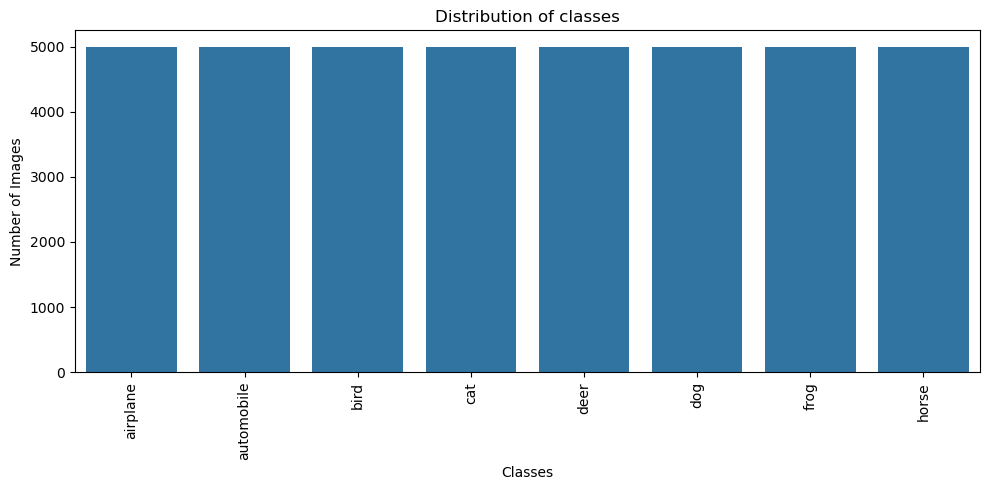

In [10]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

In [11]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

## Known classes

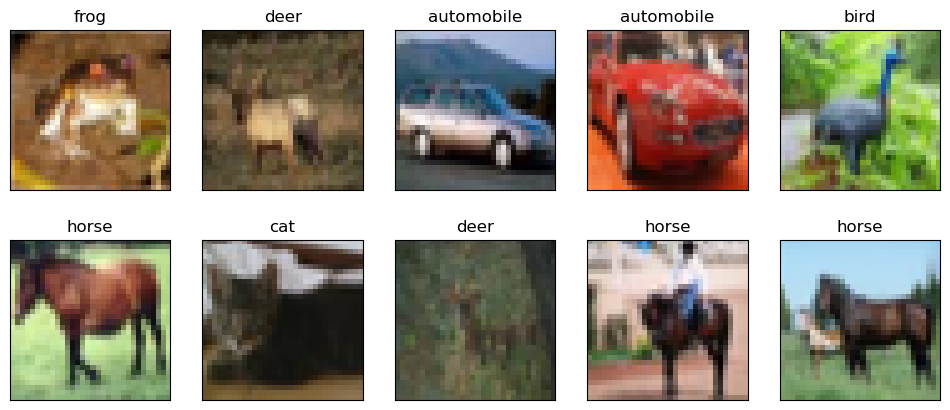

In [12]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

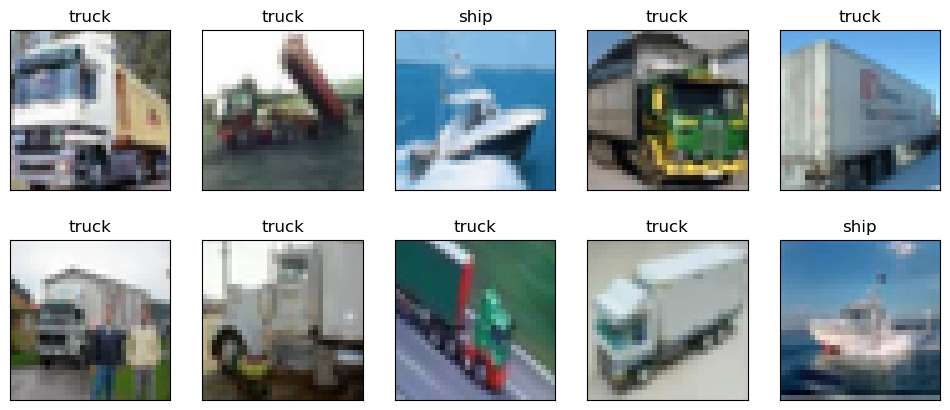

In [13]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [14]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [16]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=256,
    shuffle=False
)

# Fit simple CNN for classification

In [199]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [200]:
my_model = build_simple_cnn()

### Compile model

In [201]:
my_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Fit model

In [202]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
125/125 [==============================] - 50s 394ms/step - loss: 1.8666 - accuracy: 0.3390 - val_loss: 1.5599 - val_accuracy: 0.4316
Epoch 2/20
125/125 [==============================] - 53s 424ms/step - loss: 1.4034 - accuracy: 0.4886 - val_loss: 1.1793 - val_accuracy: 0.5685
Epoch 3/20
125/125 [==============================] - 52s 418ms/step - loss: 1.2392 - accuracy: 0.5481 - val_loss: 1.0352 - val_accuracy: 0.6223
Epoch 4/20
125/125 [==============================] - 56s 445ms/step - loss: 1.1166 - accuracy: 0.5939 - val_loss: 0.9687 - val_accuracy: 0.6465
Epoch 5/20
125/125 [==============================] - 60s 479ms/step - loss: 1.0354 - accuracy: 0.6248 - val_loss: 0.9013 - val_accuracy: 0.6749
Epoch 6/20
125/125 [==============================] - 60s 477ms/step - loss: 0.9671 - accuracy: 0.6509 - val_loss: 0.8371 - val_accuracy: 0.7005
Epoch 7/20
125/125 [==============================] - 59s 474ms/step - loss: 0.9057 - accuracy: 0.6718 - val_loss: 0.8058 - val_ac

### Get intermediate models

In [205]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

In [302]:
# Step 1: Get 1000 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 1000), random_state=SEED, shuffle=True
)

# Step 2: Get 4000 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4000), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [303]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [304]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=False, seed=SEED)
subset_test_flow = train_generator.flow(X_unknown_subset, y_unknown_subset, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [305]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 0s 108ms/step


In [306]:
train_features_cnn.shape, test_features_cnn.shape

((5000, 2048), (1000, 2048))

### Reduce feature number

In [307]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [308]:
train_reduced_cnn.shape, test_reduced_cnn.shape

((5000, 256), (1000, 256))

### Fit isolation forest

In [309]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)
    outlier_indices = np.where(predictions == -1)[0]

    # Select only the outliers from the original arrays
    return anomaly_scores, outlier_indices

In [310]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [311]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [312]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.2, 
    train_features = train_features_cnn, 
    test_features = train_features_cnn
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

### Display results

In [313]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.025207  -0.051864   0.073756   0.021963    airplane
1      1    0.007880  -0.060958   0.055299   0.019583  automobile
2      2    0.022914  -0.065988   0.076888   0.020576        bird
3      3    0.014442  -0.051996   0.071953   0.019767         cat
4      4    0.028212  -0.064743   0.068022   0.020307        deer
5      5    0.013903  -0.049332   0.067423   0.020536         dog
6      6    0.014495  -0.065383   0.067975   0.019265        frog
7      7    0.012316  -0.045286   0.063221   0.019141       horse
8      8    0.031631  -0.044818   0.077998   0.019491        ship
9      9    0.010871  -0.049429   0.058842   0.019651       truck


In [314]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     68    airplane
1      1    159  automobile
2      2     53        bird
3      3    127         cat
4      4     41        deer
5      5    113         dog
6      6    119        frog
7      7    135       horse
8      8     43        ship
9      9    142       truck


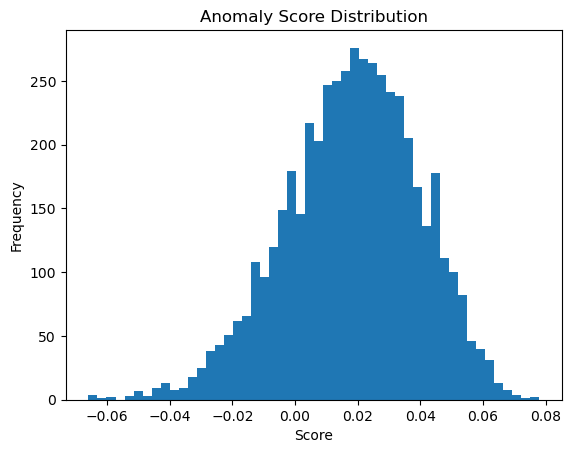

In [315]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [316]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 0s 112ms/step


In [317]:
train_features_dense.shape, test_features_dense.shape

((5000, 128), (1000, 128))

In [318]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = train_features_dense
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [319]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.042875  -0.039823   0.093458   0.024444    airplane
1      1    0.023402  -0.085886   0.089377   0.031758  automobile
2      2    0.049912  -0.033434   0.093042   0.022979        bird
3      3    0.057749  -0.080907   0.096500   0.021657         cat
4      4    0.028468  -0.088952   0.092804   0.033788        deer
5      5    0.046978  -0.056368   0.094125   0.029098         dog
6      6    0.030224  -0.063704   0.094074   0.031971        frog
7      7    0.034880  -0.070742   0.096696   0.032433       horse
8      8    0.055363  -0.039503   0.094007   0.021351        ship
9      9    0.049594  -0.059443   0.092726   0.026079       truck


In [320]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     32    airplane
1      1    112  automobile
2      2     14        bird
3      3      9         cat
4      4    104        deer
5      5     33         dog
6      6     99        frog
7      7     71       horse
8      8      3        ship
9      9     23       truck


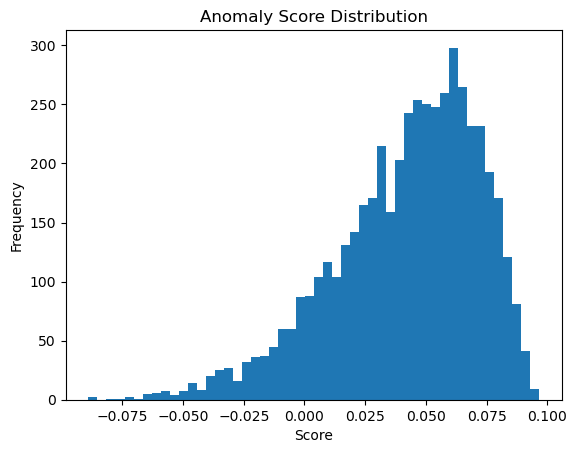

In [321]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [322]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 0s 113ms/step


In [323]:
train_features_logits.shape, test_features_logits.shape

((5000, 8), (1000, 8))

In [324]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = train_features_logits
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [325]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.082961  -0.075274   0.157000   0.047087    airplane
1      1    0.039046  -0.172333   0.147206   0.056365  automobile
2      2    0.102978  -0.044634   0.155632   0.039263        bird
3      3    0.098964  -0.074874   0.156771   0.045116         cat
4      4    0.083527  -0.088749   0.157301   0.047363        deer
5      5    0.064891  -0.130202   0.154804   0.061798         dog
6      6    0.058865  -0.126833   0.153729   0.055377        frog
7      7    0.054113  -0.145553   0.153701   0.064717       horse
8      8    0.103651  -0.095708   0.157306   0.036719        ship
9      9    0.087028  -0.094581   0.155703   0.043031       truck


In [326]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     34    airplane
1      1    120  automobile
2      2     10        bird
3      3     24         cat
4      4     27        deer
5      5     70         dog
6      6     83        frog
7      7    106       horse
8      8      6        ship
9      9     20       truck


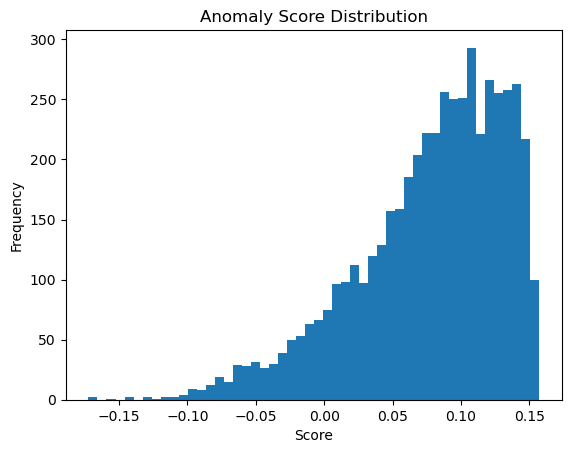

In [327]:
show_anomaly_score_plot(anomaly_scores)

## Model output

In [328]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 0s 111ms/step


In [329]:
train_features.shape, test_features.shape

((5000, 8), (1000, 8))

In [330]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = train_features_logits
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [331]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.082961  -0.075274   0.157000   0.047087    airplane
1      1    0.039046  -0.172333   0.147206   0.056365  automobile
2      2    0.102978  -0.044634   0.155632   0.039263        bird
3      3    0.098964  -0.074874   0.156771   0.045116         cat
4      4    0.083527  -0.088749   0.157301   0.047363        deer
5      5    0.064891  -0.130202   0.154804   0.061798         dog
6      6    0.058865  -0.126833   0.153729   0.055377        frog
7      7    0.054113  -0.145553   0.153701   0.064717       horse
8      8    0.103651  -0.095708   0.157306   0.036719        ship
9      9    0.087028  -0.094581   0.155703   0.043031       truck


In [332]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     34    airplane
1      1    120  automobile
2      2     10        bird
3      3     24         cat
4      4     27        deer
5      5     70         dog
6      6     83        frog
7      7    106       horse
8      8      6        ship
9      9     20       truck


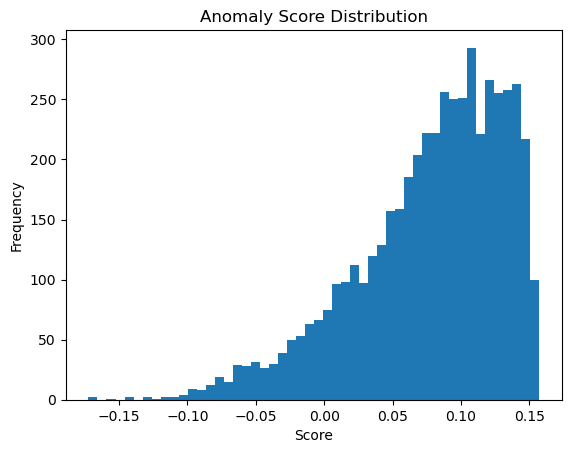

In [333]:
show_anomaly_score_plot(anomaly_scores)